In [25]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [26]:
import math

import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt

from copy import deepcopy

from utils import lists


In [27]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]

In [28]:
header, events, timing = lists.lstRead(FILE_PATH)

In [29]:
header

'ctm=80\r\ndtm=4000\r\nsen=3\r\ncoi=3\r\naui=a003\r\nauo=0\r\nauxsys=0\r\ndac=0\r\ndiguse=0\r\ndigval=0\r\nrtprena=1\r\nrtpreset=360.000     \r\nautoinc=0 \r\nsavedata=3 \r\nmpafmt=asc\r\nsephead=0 \r\nfmt=dat\r\nsmoothpts=5 \r\n[ADC1]\r\nrange=2048\r\nactive=2\r\nprena=0 \r\nltpreset=1000.000    \r\nroipreset=3000        \r\nroimin=100\r\nroimax=155\r\ncaloff=0.000000\r\ncalfact=1.000000\r\ncalfact2=0\r\ncalfact3=0\r\ncalunit=keV\r\ncaluse=0 \r\nREPORT-FILE from 01/19/2023 12:15:28 - 12:21:28.800  written 01/19/2023 12:23:39\r\ncmline0=01/19/2023 12:15:28 - 12:21:28.800 \r\ncmline1=1A\r\n[ADC2]\r\nrange=2048\r\nactive=2\r\nprena=0 \r\nltpreset=1000.000    \r\nroipreset=3000        \r\nroimin=100\r\nroimax=150\r\ncaloff=0.000000\r\ncalfact=1.000000\r\ncalfact2=0\r\ncalfact3=0\r\ncalunit=keV\r\ncaluse=0 \r\nREPORT-FILE from 01/19/2023 12:15:28 written 01/19/2023 12:23:39\r\ncmline0=01/19/2023 12:15:28\r\ncmline1=1B\r\n[ADC3]\r\nrange=2048\r\nactive=0\r\nprena=0 \r\nltpreset=1000.000    

In [30]:
len(events)

8

In [31]:
len(timing)

360030

In [32]:
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events,coin,zdrop)

binwidth = 2   ##### SET BINNING HERE #####
bins_x = int(chn[0]/binwidth)
bins_y = int(chn[1]/binwidth)

inds_multi = [ind for ind in range(8) if coin[ind]]
chmin = [0,0]
chmax = [chn[inds_multi[0]],chn[inds_multi[1]]]
nbins = [chn[inds_multi[0]]+1,chn[inds_multi[1]]+1]
nbins = [math.floor(nb/binwidth) for nb in nbins]
bins=[np.linspace(chmin[0],chmax[0],nbins[0]),np.linspace(chmin[1],chmax[1],nbins[1])]
print(f'channels used are {inds_multi}')
print(f'number of bins = {nbins}')
lhist,xed,yed = np.histogram2d(outLists[0],outLists[1],bins=bins)

channels used are [0, 1]
number of bins = [1024, 1024]


In [33]:
# Make colormap
customMap = mc.LinearSegmentedColormap.from_list(name='WKBGRY',
												 colors=[(1,1,1),(0,0,0),[1,1,0],[1,0,0]],
												 N = 200)

# Define the colors and their positions
colors = [
    (0.0, 'purple'),
    (0.2, 'blue'),
    (0.4, 'green'),
    (0.6, 'yellow'),
    (0.8, 'orange'),
    (1.0, 'red')
]

colors = [
    (0.0, 'blue'),
    (0.1, 'green'),
    (0.3, 'yellow'),
    (0.6, 'orange'),
    (1.0, 'red')
]

# Create the colormap
cmap = mc.LinearSegmentedColormap.from_list('my_map', colors)
cmap.set_under(color='white')  

In [34]:


cut = 4


# create projections of the 2d histogram
pro_x = np.zeros(bins_x)
pro_y = np.zeros(bins_y)
for i in range(bins_x-1): pro_x[i] = sum(lhist[i,:])
for i in range(bins_y-1): pro_y[i] = sum(lhist[:,i])
# Scan backward from end of the projections, 
# if 5 consecutive bins sum to greater than 3,
# place the bound at the centre of the sum.
for i in reversed(range(bins_x-3)):
	if i == 3:
		bound_x = bins_x
		print('no good data found!')
		break
	if sum(pro_x[i-2:i+2]) > cut:
		print(i)
		bound_x = int(i*1.1)
		if bound_x >= bins_x:
			bound_x = bins_x
		break
for i in reversed(range(bins_y-3)):
	if i == 3:
		bound_y = bins_y
		print('no good data found!')
		break
	if sum(pro_y[i-2:i+2]) > cut:
		bound_y = int(i*1.1)
		if bound_y >= bins_y:
			bound_y = bins_y
		break
# create reduced 2d histogram
print(f'auto-bound on X = {bound_x}')
print(f'auto-bound on Y = {bound_y}')
bhist = lhist[0:bound_x,0:bound_y]
#-----------------------------------------------------------------------------

#%%-----------------------------------------------------------------------------
# apply lower threshold to remove noise events 
#-----------------------------------------------------------------------------
# create reduced 2d histogram

thresh_x = 2
thresh_y = 2

bthist = deepcopy(bhist)
bthist[0:bound_x,0:thresh_y] = 0
bthist[0:thresh_x,0:bound_y] = 0

# create projections of the 2d histogram
prot_x = np.zeros(bound_x)
prot_y = np.zeros(bound_y)
for i in range(bound_x-1): prot_x[i] = sum(bthist[i,:])
for i in range(bound_y-1): prot_y[i] = sum(bthist[:,i])

651
auto-bound on X = 716
auto-bound on Y = 1024


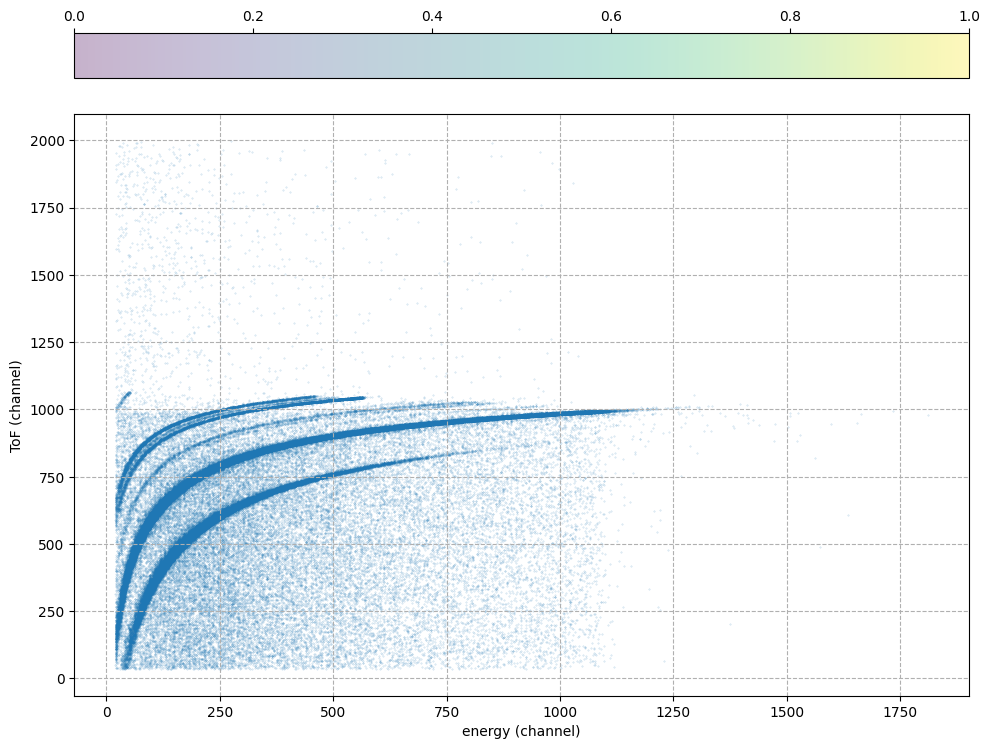

In [35]:
# plot bounded 2d hist
bextent = [0,bound_x,0,bound_y]
# Plot
plt.figure(figsize=(10,8))
#plt.imshow(bthist.T,cmap=cmap,origin='lower',interpolation='none',vmin=0.1,extent=bextent)
plt.scatter(outLists[0], outLists[1], alpha=0.3, s=0.1)
plt.colorbar(location='top')
plt.grid(linestyle='--')

#xticks = plt.xticks()
#plt.xticks(xticks * 2)


plt.xlabel('energy (channel)')
plt.ylabel('ToF (channel)')
#plt.xlim((0,bound_x))
#plt.ylim((0,600))
#plt.title('bounded')
plt.tight_layout()


## Testing BGM with polynomial-basis

In [87]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import PolynomialFeatures

# Fit the Bayesian Gaussian Mixture model
n_components = 10  # Start with more components than you expect
bgm = BayesianGaussianMixture(n_components=n_components, random_state=42)
X = np.array([outLists[0], outLists[1]]).T
X = PolynomialFeatures(degree=2, include_bias=True).fit_transform(X)

(333937, 6)


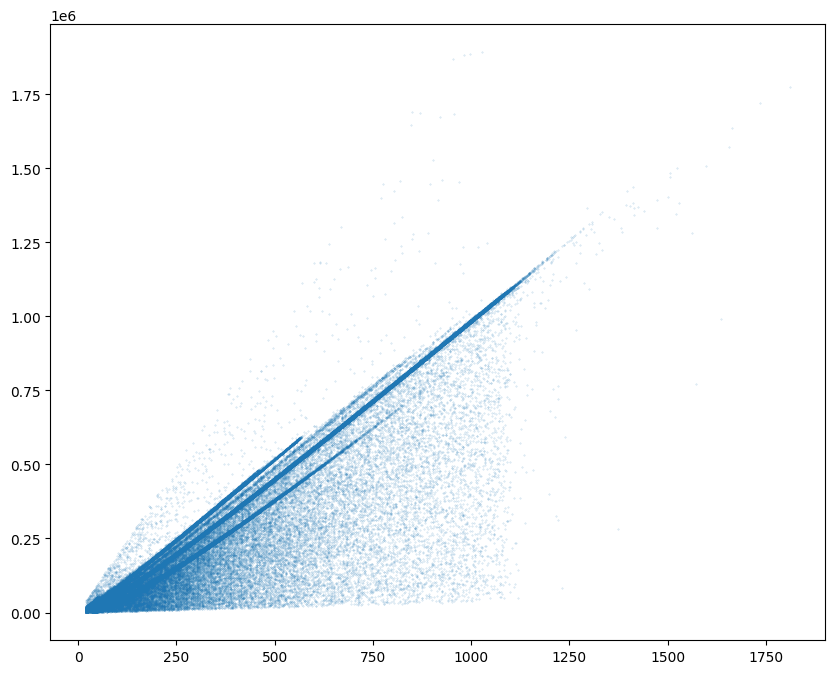

In [89]:
from sklearn.decomposition import PCA
print(X.shape)
plt.figure(figsize=(10,8))
plt.scatter(X[:,1], X[:,4], alpha=0.3, s=0.1)
# x, y, x^2, xy, y^2


## normalizing -> PCA

Text(0.5, 1.0, 'normalized')

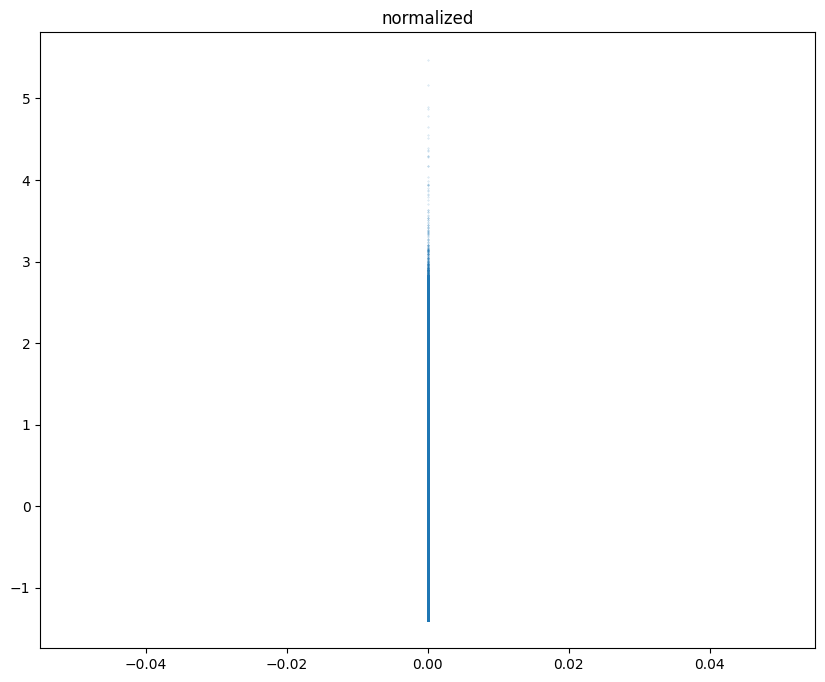

In [90]:

from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(X)

plt.figure(figsize=(10,8))
plt.scatter(scaled[:,0], scaled[:,1], alpha=0.3, s=0.1)
plt.title("normalized")


In [91]:

pca = PCA(n_components=2)
transformed = pca.fit_transform(scaled)
print(pca.components_)
print(pca.explained_variance_ratio_)


[[-0.          0.46278284  0.41176905  0.44112335  0.48887231  0.42742527]
 [-0.         -0.36918541  0.5798268  -0.47195835 -0.17174385  0.52465453]]
[0.79902903 0.18363102]


Text(0.5, 1.0, 'PCA 2 components')

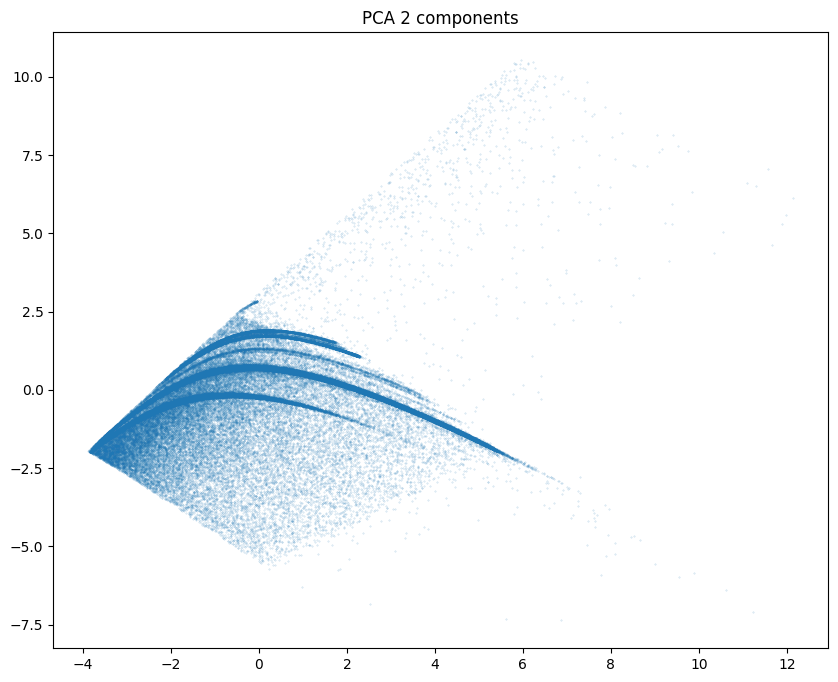

In [92]:

plt.figure(figsize=(10,8))
plt.scatter(transformed[:,0], transformed[:,1], alpha=0.3, s=0.1)
plt.title("PCA 2 components")

In [79]:

bgm.fit(X)

# Effective number of components
n_effective = np.sum(bgm.weights_ > 0.01)

c:\Users\albin\Documents\GitHub\ds-iba\.venv\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


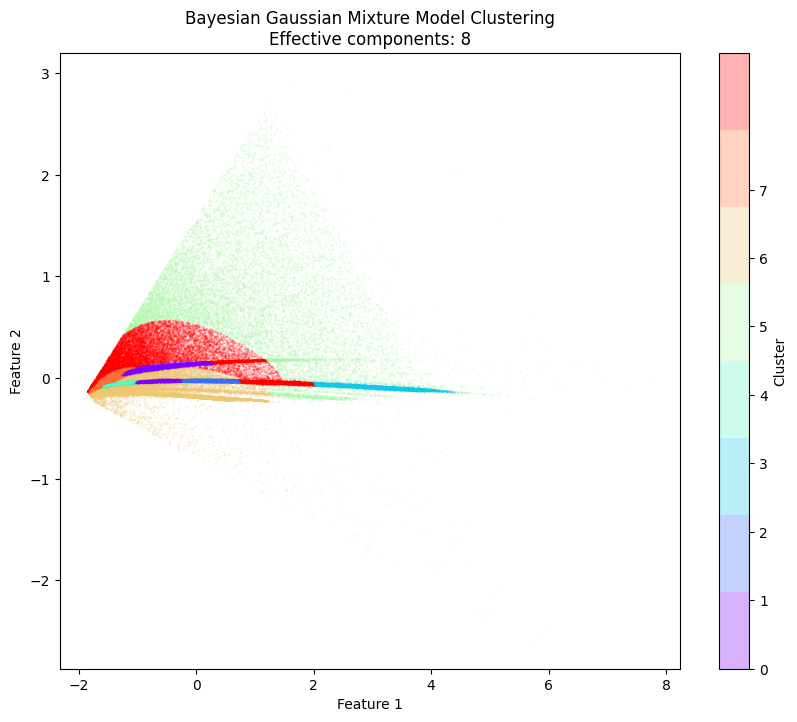

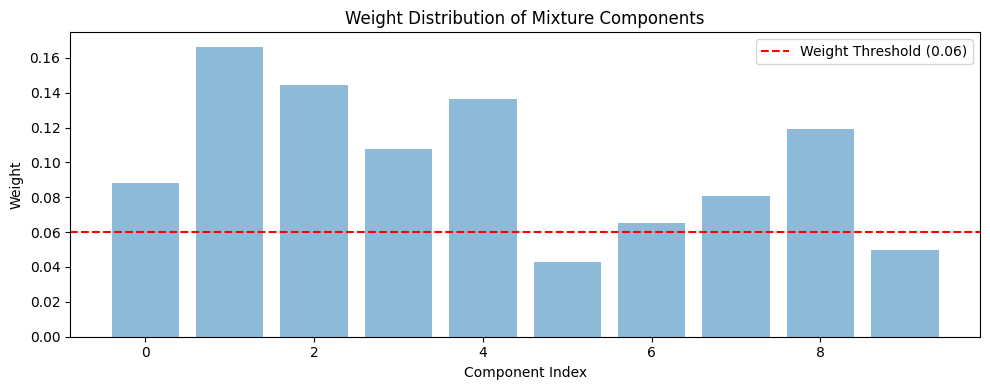

Effective number of components: 8


In [84]:
from matplotlib.colors import LinearSegmentedColormap

weights = bgm.weights_
effective_components = np.sum(weights > 0.06)

# Predict cluster labels
labels = bgm.predict(X)

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, effective_components))
cmap = LinearSegmentedColormap.from_list("custom", colors, N=effective_components)

# Plot the results
plt.figure(figsize=(10, 8))

# Plot data points
scatter = plt.scatter(transformed[:,0], transformed[:,1], c=labels, cmap=cmap, alpha=0.3, s=0.1)

# Add colorbar
plt.colorbar(scatter, label='Cluster', ticks=range(effective_components))

plt.title(f'Bayesian Gaussian Mixture Model Clustering\nEffective components: {effective_components}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot weight distribution
plt.figure(figsize=(10, 4))
plt.bar(range(n_components), bgm.weights_, alpha=0.5)
plt.title('Weight Distribution of Mixture Components')
plt.xlabel('Component Index')
plt.ylabel('Weight')
plt.axhline(y=0.06, color='r', linestyle='--', label='Weight Threshold (0.06)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Effective number of components: {effective_components}")

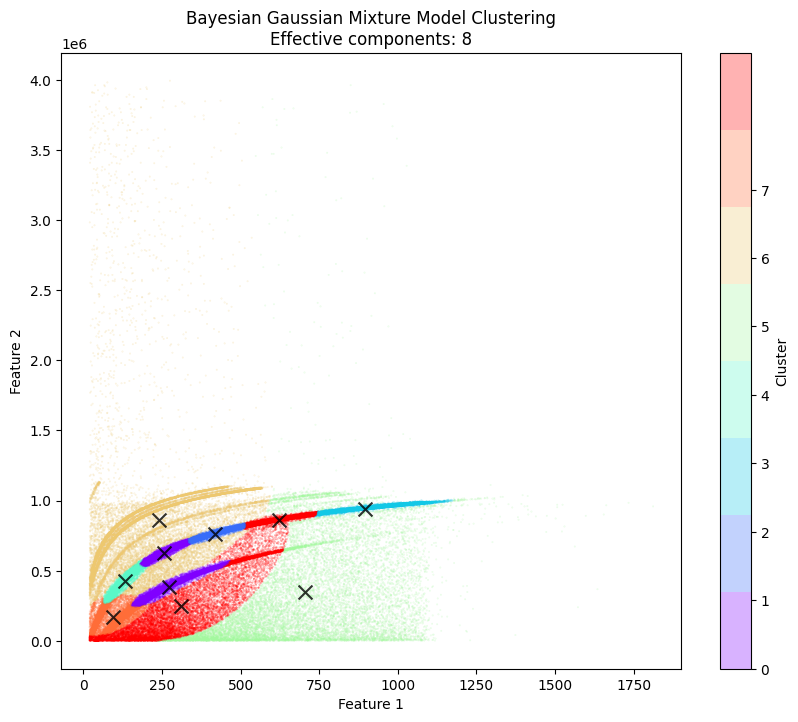

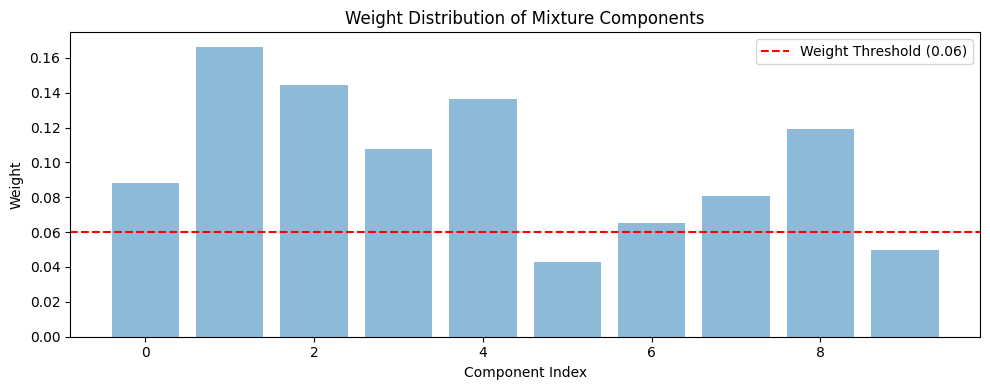

Effective number of components: 8


In [82]:
from matplotlib.colors import LinearSegmentedColormap

weights = bgm.weights_
effective_components = np.sum(weights > 0.06)

# Predict cluster labels
labels = bgm.predict(X)

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, effective_components))
cmap = LinearSegmentedColormap.from_list("custom", colors, N=effective_components)

# Plot the results
plt.figure(figsize=(10, 8))

# Plot data points
scatter = plt.scatter(X[:, 0], X[:, 4], c=labels, cmap=cmap, alpha=0.3, s=0.1)

# Plot cluster centers
centers = bgm.means_
plt.scatter(centers[:, 0], centers[:, 4], c='black', s=100, alpha=0.8, marker='x')

# Add colorbar
plt.colorbar(scatter, label='Cluster', ticks=range(effective_components))

plt.title(f'Bayesian Gaussian Mixture Model Clustering\nEffective components: {effective_components}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Plot weight distribution
plt.figure(figsize=(10, 4))
plt.bar(range(n_components), bgm.weights_, alpha=0.5)
plt.title('Weight Distribution of Mixture Components')
plt.xlabel('Component Index')
plt.ylabel('Weight')
plt.axhline(y=0.06, color='r', linestyle='--', label='Weight Threshold (0.06)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Effective number of components: {effective_components}")